In [2]:
# (0) 関数の定義、config
from scipy.special import erf, erfinv
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import pandas as pd
from mpmath import erfinv, mp

##　読み込みファイルの指定
# hold_file = "csv_files/hold_time.csv"
# setup_file = "csv_files/setup_time.csv"
# jitter_file = "csv_files/jitter.csv"
# power_file = "csv_files/power.csv"

hold_file = "timing/hold_time.csv"
setup_file = "timing/setup_time.csv"
jitter_file = "jitter.csv"
power_file = "power.csv"

def mp_to_float_exact(mp):
    mp_str = str(mp)
    j = 2
    for i in range(2, len(mp_str)):
        if mp_str[i] == '0':
            j += 1
        else:
            break
    return j-1

def calc_error(t,setup,hold,total):
    return 1-erf((t-setup-hold)/(2*total*2**(1/2)))

def calc_error_mp(t,setup,hold,total):
    mp.dps = 1000
    t = mp.mpf(t)
    setup = mp.mpf(setup)
    hold = mp.mpf(hold)
    total = mp.mpf(total)
    return 1-mp.erf((t-setup-hold)/(2*total*2**(1/2)))

def calc_total(j_setup,j_hold,jitter,bai):
    return (bai*(jitter**2) + j_setup**2 + j_hold**2)**(1/2)

def calc_total_mp(j_setup,j_hold,jitter,bai):
    mp.dps = 1000
    j_setup = mp.mpf(j_setup)
    j_hold = mp.mpf(j_hold)
    jitter = mp.mpf(jitter)
    bai = mp.mpf(bai)
    return (bai*(jitter**2) + j_setup**2 + j_hold**2)**(1/2)

def calc_t(error, setup, hold, total):
    if error <= 0 or error >= 1:
        raise ValueError("error must be between 0 and 1 (exclusive).")

    mp.dps = 1000
    error = mp.mpf(error)
    setup = mp.mpf(setup)
    hold = mp.mpf(hold)
    total = mp.mpf(total)
    adjusted_error = mp.mpf(1) - error
    t = setup + hold + 2 * total * (2**0.5) * erfinv(adjusted_error)
    #return float(t)  # 必要に応じてfloatに変換

    # 逆誤差関数を使って t を計算
    return setup + hold + 2 * total * (2**0.5) * erfinv(1 - error)

4.503345773958591e-13
DFF Min. Ic = 60μA, Clock Cycle Time = 55ps, Error rate = e-14
XOR Min. Ic = 60μA, Clock Cycle Time = 55ps, Error rate = e-2
3.3446123331363016e-13
DFF Min. Ic = 60μA, Clock Cycle Time = 55ps, Error rate = e-20
XOR Min. Ic = 60μA, Clock Cycle Time = 55ps, Error rate = e-11


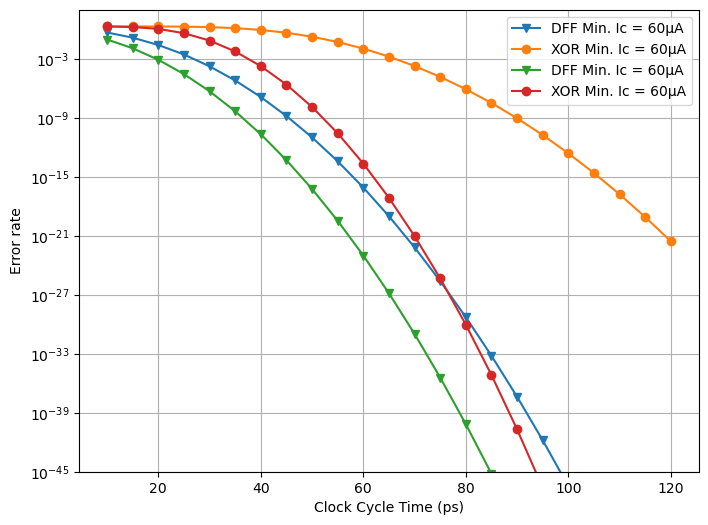

In [10]:
# (1)

# クロックサイクル時間の範囲の指定
# t_values = np.linspace(10e-12, 120e-12, 12*2-1)
# t_values_ps = [t*10**12 for t in t_values]
t_values_ps = np.linspace(10, 120, 12*2-1)

holds = pd.read_csv(hold_file,names=["LIc","Ic","mean","std"])
sets = pd.read_csv(setup_file,names=["LIc","Ic","mean","std"])
# jitters = pd.read_csv(jitter_file,names=["LIc","Ic","mean","std"])
jitters = pd.read_csv(jitter_file,names=["LIc","Ic","Vb","Ibf","Bc","mean","std"])

LIc = 3.5 * 60.8
Ics = [60]
# Ics = [50,60,70,80,90,100]
# Ics = [10,20,30,40,50,60,70,80,90,100]

clock_cycke_time = 55

plt.figure(figsize=(8, 6))
plt.rcParams['font.family'] = ''

for ic in Ics:
    # setup_mean = sets[(sets["LIc"]==LIc) & (sets["Ic"]==ic)]["mean"].values[0]*10**-12
    # setup_std = sets[(sets["LIc"]==LIc) & (sets["Ic"]==ic)]["std"].values[0]*10**-12
    # hold_mean = holds[(holds["LIc"]==LIc) & (holds["Ic"]==ic)]["mean"].values[0]*10**-12
    # hold_std = holds[(holds["LIc"]==LIc) & (holds["Ic"]==ic)]["std"].values[0]*10**-12
    # jitter = jitters[(jitters["LIc"]==LIc) & (jitters["Ic"]==ic)]["std"].values[0]
    # print(setup_mean, hold_mean, setup_std, hold_std, jitter)

    ## 揺らぎが生じるSQUIDの個数を指定
    squid_count = 10+10
    # squid_count = 20+20
    
    # total = calc_total_mp(hold_std,setup_std,jitter,squid_count)

    # total = calc_total_mp(hold_std,setup_std,jitter,squid_count)
    # error_values = [calc_error_mp(t,setup_mean,hold_mean,total) for t in t_values]
    # plt.plot(t_values_ps, error_values, marker='v', label='DFF Min. Ic = '+str(ic)+'μA')

    jitter = jitters[(jitters["Ibf"]==0.4) & (jitters["Bc"]==2.0) & (jitters["Ic"]==ic)]["std"].values[0]
    print(jitter)
    total = calc_total_mp(2.16319652e-12,1.41934909e-12,jitter,squid_count)
    error_values = [calc_error_mp(t*1e-12,4.05772322e-12,1.33039736e-12,total) for t in t_values_ps]
    plt.plot(t_values_ps, error_values, marker='v', label='DFF Min. Ic = '+str(ic)+'μA')
    for t in t_values_ps:
        if t == clock_cycke_time:
            exp_order = mp_to_float_exact(calc_error_mp(t*1e-12,4.05772322e-12,1.33039736e-12,total))
            print(f"DFF Min. Ic = {ic}μA, Clock Cycle Time = {t:.0f}ps, Error rate = e-{exp_order}")

    total = calc_total_mp(1.25392833e-12,3.44799736e-12,jitter,squid_count)
    error_values = [calc_error_mp(t*1e-12,10.56319378e-12,28.17970628e-12,total) for t in t_values_ps]
    plt.plot(t_values_ps, error_values, marker='o', label='XOR Min. Ic = '+str(ic)+'μA')
    for t in t_values_ps:
        if t == clock_cycke_time:
            exp_order = mp_to_float_exact(calc_error_mp(t*1e-12,10.56319378e-12,28.17970628e-12,total))
            print(f"XOR Min. Ic = {ic}μA, Clock Cycle Time = {t:.0f}ps, Error rate = e-{exp_order}")
            
    jitter = jitters[(jitters["Ibf"]==0.5) & (jitters["Bc"]==2.0) & (jitters["Ic"]==ic)]["std"].values[0]
    print(jitter)
    total = calc_total_mp(2.16319652e-12,1.41934909e-12,jitter,squid_count)
    error_values = [calc_error_mp(t*1e-12,-3.05772322e-12,3.03039736e-12,total) for t in t_values_ps]
    plt.plot(t_values_ps, error_values, marker='v', label='DFF Min. Ic = '+str(ic)+'μA')
    for t in t_values_ps:
        if t == clock_cycke_time:
            exp_order = mp_to_float_exact(calc_error_mp(t*1e-12,-3.05772322e-12,3.03039736e-12,total))
            print(f"DFF Min. Ic = {ic}μA, Clock Cycle Time = {t:.0f}ps, Error rate = e-{exp_order}")
            
    total = calc_total_mp(1.02643238e-12,1.81714063e-12,jitter,squid_count)
    error_values = [calc_error_mp(t*1e-12,8.72656838e-12,12.05826696e-12,total) for t in t_values_ps]
    plt.plot(t_values_ps, error_values, marker='o', label='XOR Min. Ic = '+str(ic)+'μA')
    for t in t_values_ps:
        if t == clock_cycke_time:
            exp_order = mp_to_float_exact(calc_error_mp(t*1e-12,8.72656838e-12,12.05826696e-12,total))
            print(f"XOR Min. Ic = {ic}μA, Clock Cycle Time = {t:.0f}ps, Error rate = e-{exp_order}")

# plt.axhline(y=1e-12, color='black', linestyle='--')
plt.yscale('log')
plt.ylim(1e-45, 1e2)
plt.xlabel('Clock Cycle Time (ps)')
plt.ylabel('Error rate')
plt.grid(True)
plt.legend()
plt.show()

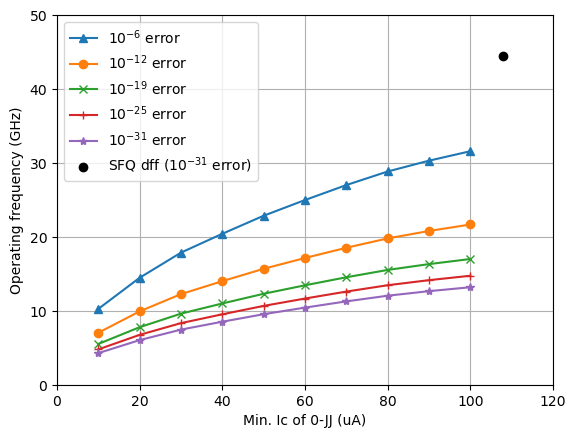

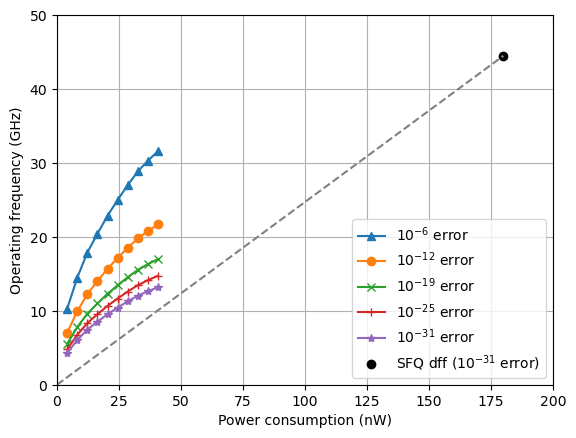

In [9]:
# (4) 特定のエラー率の時の周波数、消費電力の比較

holds = pd.read_csv(hold_file,names=["LIc","Ic","mean","std"])
sets = pd.read_csv(setup_file,names=["LIc","Ic","mean","std"])
jitters = pd.read_csv(jitter_file,names=["LIc","Ic","mean","std"])

# JTL部分を除いた、DFFのコア部分の消費電力ファイル
# dff_core_power_file = "csv_files/power_dynamic.csv"
# powers = pd.read_csv(dff_core_power_file,names=["Ic","LIc","power"])
dff_core_power_file = "power.csv"
powers = pd.read_csv(dff_core_power_file,names=["LIc","Ic","power"])


# 比較する臨界電流値のリスト
# ics = [ i for i in range(10, 110, 10)]
ics = [10,20,30,40,50,60,70,80,90,100]
# ics = [10,15,20,25,30,40,50,60,70,80,90,100]

LIc = 192.5
error_list = []

time_list_extreme = []
time_list_loose = []
time_list_tight = []
time_list_axnpu = []
time_list_sfq = []
time_list_worst = []
power_list = []

for ic in ics:
    # タイミングパラメータの取得
    setup_mean = sets[(sets["LIc"]==LIc) & (sets["Ic"]==ic)]["mean"].values[0]*10**-12
    setup_std = sets[(sets["LIc"]==LIc) & (sets["Ic"]==ic)]["std"].values[0]*10**-12
    hold_mean = holds[(holds["LIc"]==LIc) & (holds["Ic"]==ic)]["mean"].values[0]*10**-12
    hold_std = holds[(holds["LIc"]==LIc) & (holds["Ic"]==ic)]["std"].values[0]*10**-12
    jitter = jitters[(jitters["LIc"]==LIc) & (jitters["Ic"]==ic)]["std"].values[0]
    # power_w = powers[powers["Ic"]==ic]["power"].values
    power_nW = powers[powers["Ic"]==ic]["power"].values*10**9

    # 揺らぎの合計の計算
    ## 揺らぎが生じるSQUIDの個数を指定
    squid_count = 10+10
    # squid_count = 20+20
    
    # total = calc_total(hold_std,setup_std,jitter,squid_count)
    total = calc_total_mp(hold_std,setup_std,jitter,squid_count)

    # 特定のエラー率に対するクロックサイクル時間の計算
    time_extreme = calc_t(1*10**-3,setup_mean,hold_mean,total)
    time_loose = calc_t(1*10**-6,setup_mean,hold_mean,total)
    time_axnpu = calc_t(1*10**-12,setup_mean,hold_mean,total)
    time_tight = calc_t(1*10**-19,setup_mean,hold_mean,total)
    time_sfq = calc_t(1*10**-25,setup_mean,hold_mean,total)
    time_worst = calc_t(1*10**-31,setup_mean,hold_mean,total)
    time_list_extreme.append(time_extreme)
    time_list_loose.append(time_loose)
    time_list_axnpu.append(time_axnpu)
    time_list_tight.append(time_tight)
    time_list_sfq.append(time_sfq)
    time_list_worst.append(time_worst)
    power_list.append(power_nW)

# クロックサイクル時間を周波数に変換
freqs_extreme = [(1/t)*1e-9 for t in time_list_extreme]
freqs_loose = [(1/t)*1e-9 for t in time_list_loose]
freqs_axnpu = [(1/t)*1e-9 for t in time_list_axnpu]
freqs_tight = [(1/t)*1e-9 for t in time_list_tight]
freqs_sfq = [(1/t)*1e-9 for t in time_list_sfq]
freqs_worst = [(1/t)*1e-9 for t in time_list_worst]

# print(power_w)
# print(power_nW)

# 臨界電流地と周波数のグラフのプロット
plt.rcParams['font.family'] = ''
# plt.plot(ics, freqs_extreme, marker='s', label=r'$10^{-3}$ error')
plt.plot(ics, freqs_loose, marker='^', label=r'$10^{-6}$ error')
plt.plot(ics, freqs_axnpu, marker='o', label=r'$10^{-12}$ error')
plt.plot(ics, freqs_tight, marker='x', label=r'$10^{-19}$ error')
plt.plot(ics, freqs_sfq, marker='+', label=r'$10^{-25}$ error')
plt.plot(ics, freqs_worst, marker='*', label=r'$10^{-31}$ error')
plt.scatter(108, 44.5, color='black', label=r'SFQ dff ($10^{-31}$ error)')
# plt.plot([0, 108], [0, 50], linestyle='--', color='gray')
plt.xlabel('Min. Ic of 0-JJ (uA)')
plt.ylabel('Operating frequency (GHz)')
plt.ylim(0, 50)
plt.xlim(0, 120)
plt.grid(True)
plt.legend() 
plt.show()

# 消費電力と周波数のグラフのプロット
# plt.plot(power_nW, freqs_extreme, marker='s', label=r'$10^{-3}$ error')
plt.plot(power_list, freqs_loose, marker='^', label=r'$10^{-6}$ error')
plt.plot(power_list, freqs_axnpu, marker='o', label=r'$10^{-12}$ error')
plt.plot(power_list, freqs_tight, marker='x', label=r'$10^{-19}$ error')
plt.plot(power_list, freqs_sfq, marker='+', label=r'$10^{-25}$ error')
plt.plot(power_list, freqs_worst, marker='*', label=r'$10^{-31}$ error')
plt.scatter(1800*0.2*0.5, 44.5, color='black', label=r'SFQ dff ($10^{-31}$ error)')
plt.plot([0, 1800*0.2*0.5], [0, 44.5], linestyle='--', color='gray')
plt.xlabel('Power consumption (nW)')
plt.ylabel('Operating frequency (GHz)')
plt.ylim(0, 50)
plt.xlim(0, 200)
plt.grid(True)
plt.legend()
plt.show()


In [10]:
for i in range(len(ics)):
    print(ics[i], float(freqs_loose[i]))

10 10.260238609660947
20 14.47414896420354
30 17.874455372878405
40 20.423367216625195
50 22.86429287145725
60 24.987065765472334
70 27.01121691951599
80 28.84706928001294
90 30.31150455708386
100 31.589179543451795


In [11]:
for i in range(len(ics)):
    print(ics[i], float(freqs_worst[i]))

10 4.277432229628437
20 6.037346660839157
30 7.4567333390654635
40 8.52460781972018
50 9.542147703161554
60 10.431668411944047
70 11.273801205504169
80 12.042912268350308
90 12.655354366013896
100 13.18997406606553


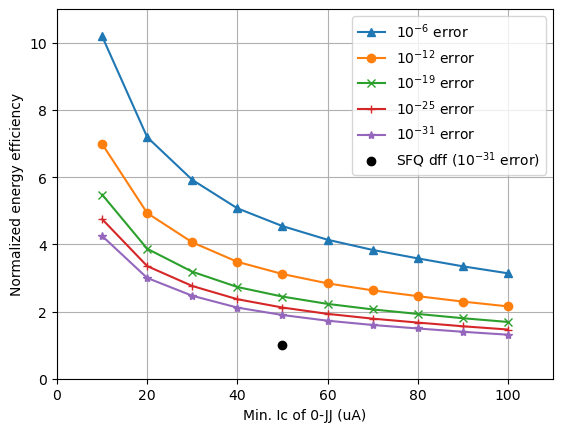

In [12]:
gops_extreme = [f/p for p,f in zip(power_list, freqs_extreme)]
gops_loose = [f/p for p,f in zip(power_list, freqs_loose)]
gops_axnpu = [f/p for p,f in zip(power_list, freqs_axnpu)]
gops_tight = [f/p for p,f in zip(power_list, freqs_tight)]
gops_sfq = [f/p for p,f in zip(power_list, freqs_sfq)]
gops_worst = [f/p for p,f in zip(power_list, freqs_worst)]
gops_sfq_dff = 44.5/(1800*0.2*0.5)

# baseline = gops_tight[6]
# baseline = gops_sfq[6]
# baseline = gops_worst[4]
baseline = gops_sfq_dff

gops_extreme = [g/baseline for g in gops_extreme]
gops_loose = [g/baseline for g in gops_loose]
gops_axnpu = [g/baseline for g in gops_axnpu]
gops_tight = [g/baseline for g in gops_tight]
gops_sfq = [g/baseline for g in gops_sfq]
gops_worst = [g/baseline for g in gops_worst]
gops_sfq_dff = gops_sfq_dff/baseline

fig = plt.figure()
# plt.plot(ics, gops_extreme, marker='s', label=r'$10^{-3}$ error')
plt.plot(ics, gops_loose, marker='^', label=r'$10^{-6}$ error')
plt.plot(ics, gops_axnpu, marker='o', label=r'$10^{-12}$ error')
plt.plot(ics, gops_tight, marker='x', label=r'$10^{-19}$ error')
plt.plot(ics, gops_sfq, marker='+', label=r'$10^{-25}$ error')
plt.plot(ics, gops_worst, marker='*', label=r'$10^{-31}$ error')
plt.scatter(50, gops_sfq_dff, color='black', marker='o', label=r'SFQ dff ($10^{-31}$ error)')
plt.xlabel('Min. Ic of 0-JJ (uA)')
plt.ylabel('Normalized energy efficiency')
plt.xlim(0, 110)
# plt.ylim(0, 20)
plt.ylim(0, 11)
plt.legend()
plt.grid()
plt.show()